<a href="https://colab.research.google.com/gist/qbeer/1df46c5028ad976dcf497f8117046830/hw9_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
#!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import metrics
import tensorflow as tf

/Users/barnabasp/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


## Neural networks, introduction


### 1. Implement a logistic regression model on MNIST for binary classification in Numpy

* use `from sklearn.datasets import load_digits`
  * the provided data files: X_train, X_test are a split generated by the author of this exercise
  * w, b are the fitted logistic regression weight and bias, the predictions on the provided test set can be generated by: `y_pred_test = sigmoid(np.dot(w, X_test.T) + b)`
  * the binarized accuracy score should be above 98% for this particular data
* divide the data into 0 vs. 1-9. categories
  * the goal is to separate the zeros
* y = logistic(wx + b)
* optimize the model via stochastic mini-batch gradient descent until you reach above 90% accuracy on the test set

* the loss:

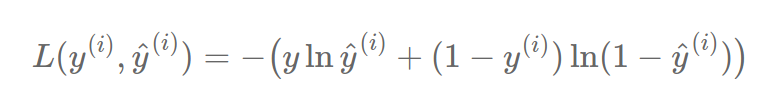

* the gradients of the mini-batch loss:

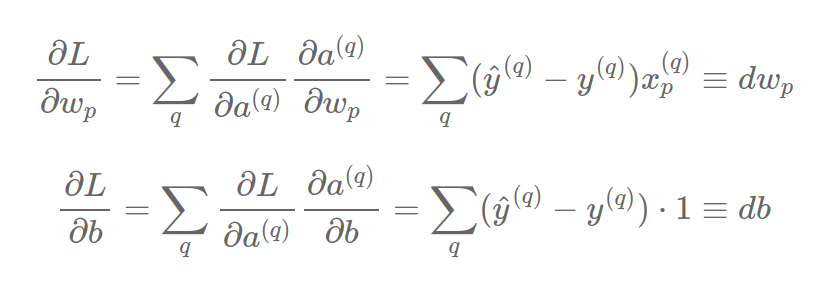

In [23]:
#Loading data
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
w = np.load('w.npy')
b = np.load('b.npy')

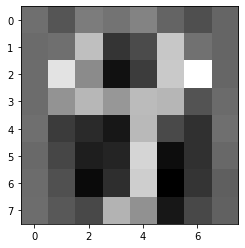

In [22]:
#to show whats in the data one can reshape
plt.imshow(X_test[1].reshape(8,8),cmap='gray')

#### Simple sigmoid and predict functions

In [78]:
def sigmoid(x):
    return 1/(1+np.e**(-x))
def predict(X,w,b):
    return sigmoid(np.dot(w, X.T) + b).T

#### Weighted
Based on description above

In [131]:
np.dot((predict(X_test,w,b) - y_test).T,X_test).shape

(1, 64)

#### B
Based on description above

In [133]:
np.dot((predict(X_test,w,b) - y_test).T,np.ones(shape=(predict(X_test,w,b) - y_test).shape)).shape

(1, 1)

#### Creating shuffle for stochastic
some help https://towardsdatascience.com/step-by-step-guide-to-building-your-own-neural-network-from-scratch-df64b1c5ab6e

In [305]:
# HELP https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
def sMiniBatchGD(X,y,w,b, batch_s=10, iterations=1, learn_rate=1):
    for it in range(iterations):
        idx = [x for x in range(len(X))] #load up the indices , maybe not the best
        random.shuffle(idx) #shuffle the indices
        X = X[idx]
        y = y[idx]
        l = len(y)
        batch_num = int(l/batch_s) # will leave out a few
#        print(l,batch_s,batch_num)
        #holder for bs and ws.
        B_b = []
        w_b = []
        #looping through the batches
        for ibatch in range(batch_num):
            x_batch = X[ibatch*batch_s:(ibatch+1)*batch_s]
            y_batch = y[ibatch*batch_s:(ibatch+1)*batch_s]
            #predict for each batch
            y_predict = predict(x_batch,w,b)
            factor = (y_predict - y_batch).T
            w_b.append(np.dot(factor,x_batch))
            B_b.append(np.dot(factor,np.ones((batch_s))))
        #feedback for the iterations
        db = np.array(B_b).flatten().mean()
        dw = np.array(w_b).reshape(batch_num,X[0].shape[0]).mean(axis=0)
        b = b - db * learn_rate
        w = w - dw * learn_rate

    return w, b

#### Train, predict, check

In [324]:
w_gd, b_gd = sMiniBatchGD(X_train,y_train,w,b,batch_s=10, iterations=1)
y_pred = predict(X_test,w_gd, b_gd).round()

Text(0.5, 103.73999999999997, 'Predicted')

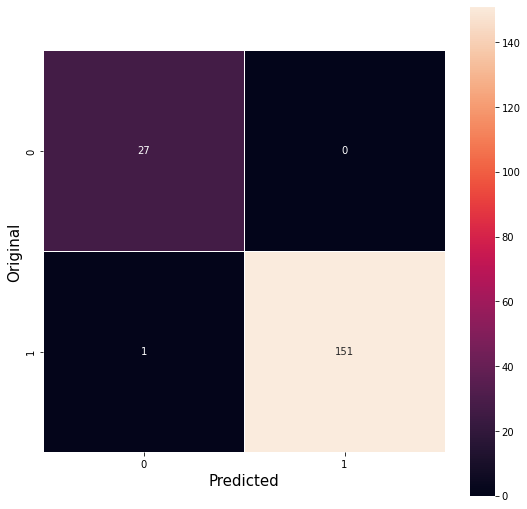

In [325]:
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, 
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True)
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)

It is quite obvious, the prediction is really good with only 1 iteration. It of course depends on the batch size as well, but for predicting if it is zero or not, it works like miracle

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]


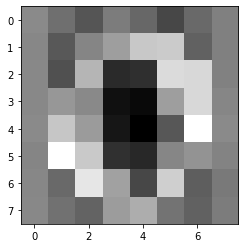

In [343]:
#looking at the first few
print(y_pred[0:5])
plt.imshow(X_test[2].reshape(8,8),cmap='gray')

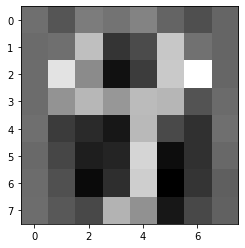

In [344]:
plt.imshow(X_test[1].reshape(8,8),cmap='gray')

### 2. MLP model in `tf.keras`

* implement a model as such:

 * 750 neuron, relu activation
 * 500 neuron, relu activation
 * 500 neuron, relu activation
 * 10 neuron, softmax activation

* use the `tf.keras.datasets.mnist` dataset in this case
* preprocess if necessary
* use the 'sgd' optimizer, log the loss ('categorical_crossentropy') and the accuracy, as well as the AUC score during training, visualize the history of these values

Closely following the code example on https://patbaa.web.elte.hu/physdm/code_examples/fully_connected.html

In [524]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Could preprocess, as it was done on the link above

In [525]:
def show_train_imgs(n=8, m=5):
    for i in range(m):
        for j in range(n):
            idx = np.random.randint(len(y_train))
            plt.subplot(int('1' + str(n) + str(j+1)))
            plt.imshow(x_train[idx], cmap='gray')
            plt.title(y_train[idx], fontsize=30)
            plt.axis('off')
        plt.show()
def show_predictions(n=5, m=5):
    for j in range(m):
        idx_start = np.random.randint(len(x_test) - n)
        preds = model.predict(x_test[idx_start:idx_start+5])
        true_labels = y_test[idx_start:idx_start+5]

        for i in range(n):
            plt.subplot(int('1' + str(n) + str(i+1)))
            predstr = 'pred: ' + str(preds[i].argmax()) + ', prob: ' + str(int(np.round(preds[i].max()*100,0))) + '%'
            plt.title(predstr + ' / true: ' + str(true_labels[i]),fontsize=10)
            plt.imshow(x_test[idx_start+i].reshape(28, 28)*255, cmap='gray')
            if(preds[i].argmax() != true_labels[i]):
                plt.scatter([14], [14], s=500, c='r')
            plt.axis('off')
        plt.show()        

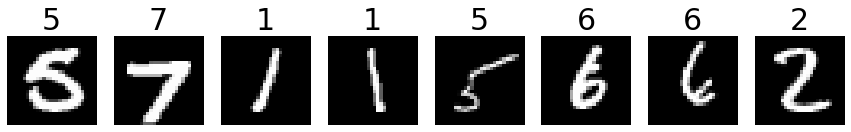

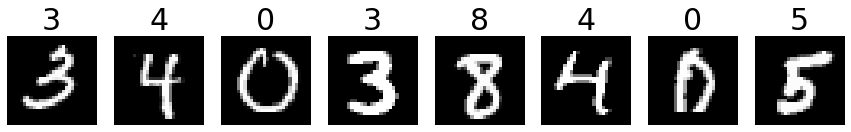

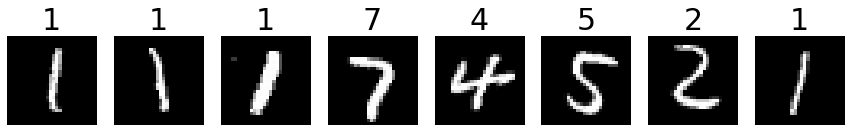

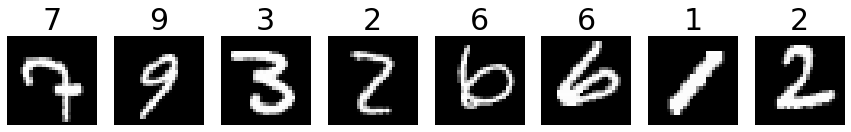

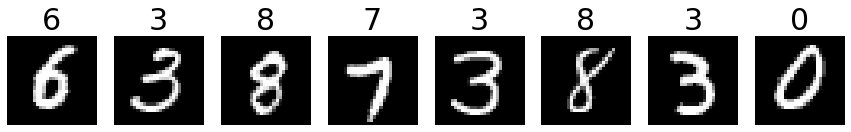

In [526]:
plt.rcParams['figure.figsize'] = (15, 5)
show_train_imgs(8)

#### Reshaping, basically flattening the pic. itself.

In [527]:
x_train = x_train.reshape(60000, 28*28)/255
x_test = x_test.reshape(10000, 28*28)/255

x_train.shape, x_test.shape, x_train.min(), x_train.max()

((60000, 784), (10000, 784), 0.0, 1.0)

In [528]:
#### onehot encoding via Tenzorflow Keras

In [529]:
y_train_oh = tf.keras.utils.to_categorical(y_train)
y_test_oh = tf.keras.utils.to_categorical(y_test)
y_train_oh[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [530]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(750, activation='relu', input_dim=784))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 750)               588750    
                                                                 
 dense_9 (Dense)             (None, 500)               375500    
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dense_11 (Dense)            (None, 10)                5010      
                                                                 
Total params: 1,219,760
Trainable params: 1,219,760
Non-trainable params: 0
_________________________________________________________________


In [531]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy', 'AUC'])

In [532]:
history = model.fit(x=x_train,
                    y=y_train_oh,
                    batch_size=64,
                    epochs=16,
                    validation_data=(x_test, y_test_oh))

Epoch 1/16
938/938 [==============================] - 12s 12ms/step - loss: 0.7620 - accuracy: 0.8245 - auc: 0.9741 - val_loss: 0.3385 - val_accuracy: 0.9030 - val_auc: 0.9919
Epoch 2/16
938/938 [==============================] - 12s 12ms/step - loss: 0.3060 - accuracy: 0.9129 - auc: 0.9930 - val_loss: 0.2621 - val_accuracy: 0.9265 - val_auc: 0.9940
Epoch 3/16
938/938 [==============================] - 10s 10ms/step - loss: 0.2494 - accuracy: 0.9289 - auc: 0.9948 - val_loss: 0.2223 - val_accuracy: 0.9366 - val_auc: 0.9954
Epoch 4/16
938/938 [==============================] - 11s 12ms/step - loss: 0.2141 - accuracy: 0.9388 - auc: 0.9959 - val_loss: 0.2049 - val_accuracy: 0.9371 - val_auc: 0.9962
Epoch 5/16
938/938 [==============================] - 10s 11ms/step - loss: 0.1876 - accuracy: 0.9457 - auc: 0.9967 - val_loss: 0.1775 - val_accuracy: 0.9477 - val_auc: 0.9970
Epoch 6/16
938/938 [==============================] - 11s 11ms/step - loss: 0.1670 - accuracy: 0.9517 - auc: 0.9972 - va

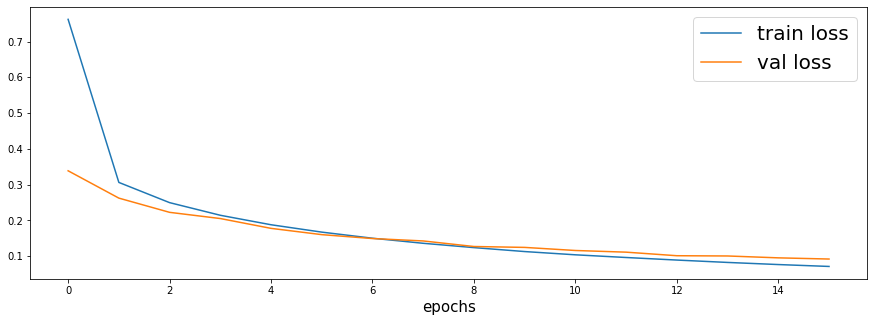

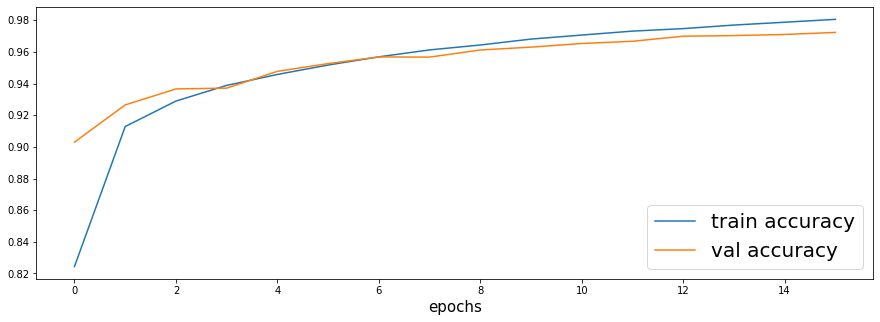

In [533]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

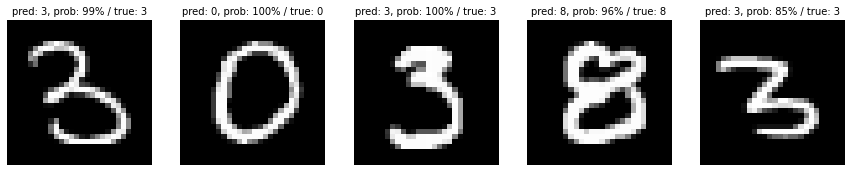

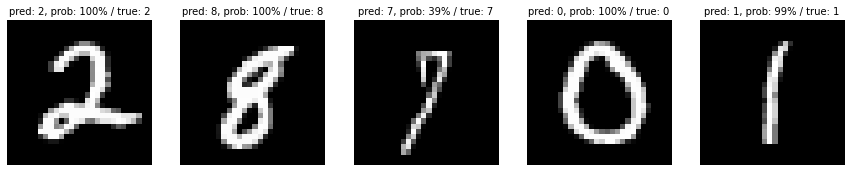

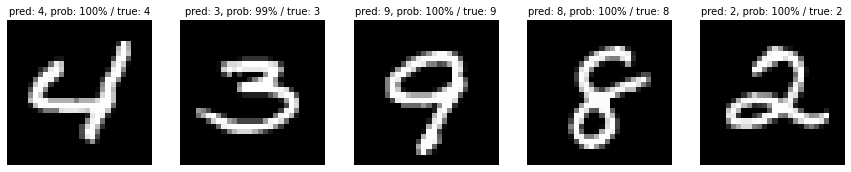

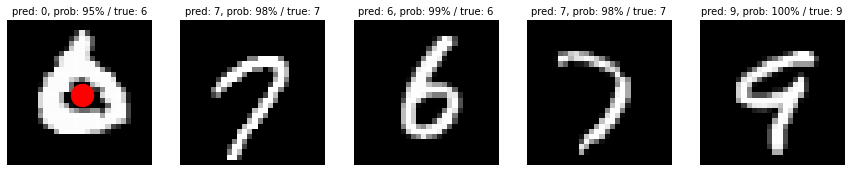

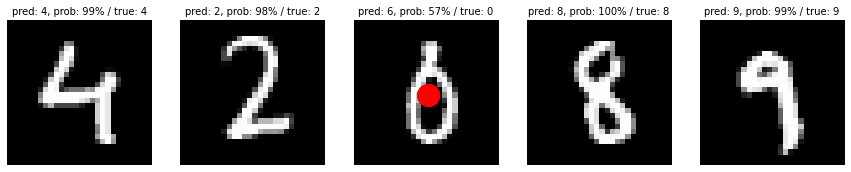

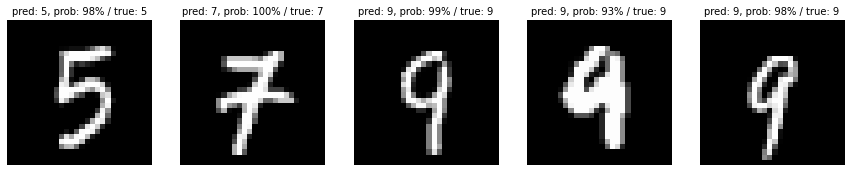

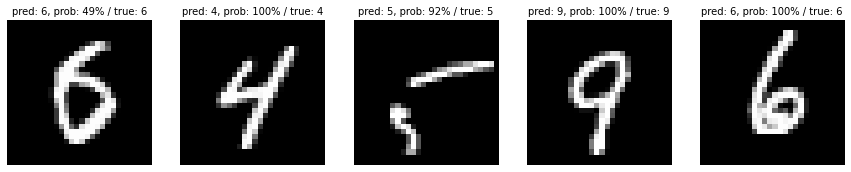

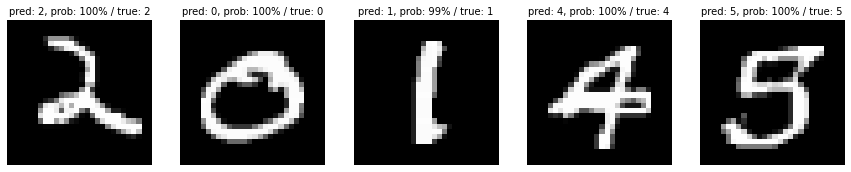

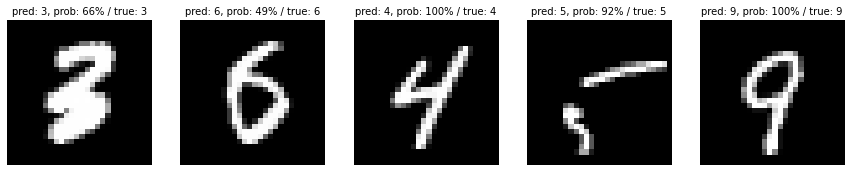

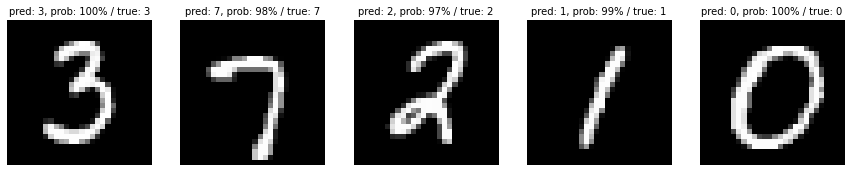

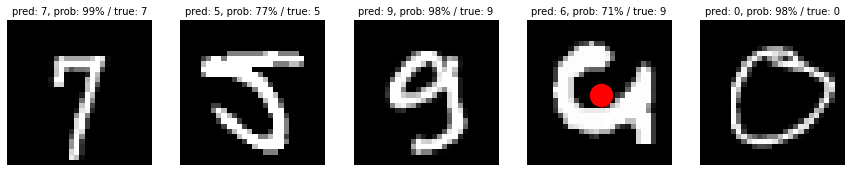

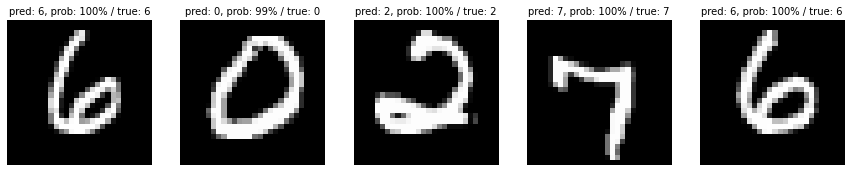

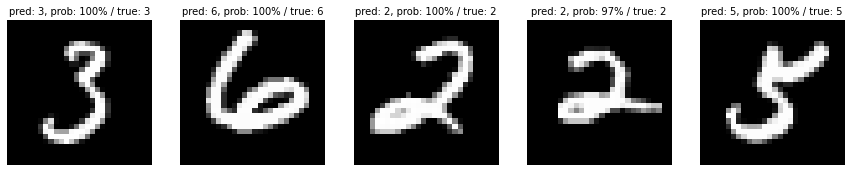

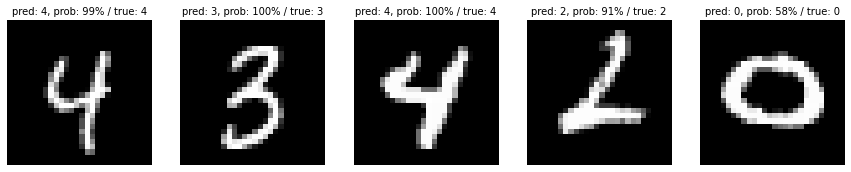

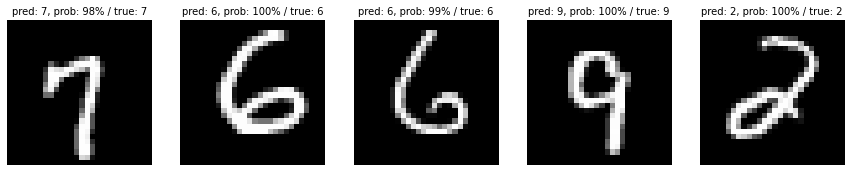

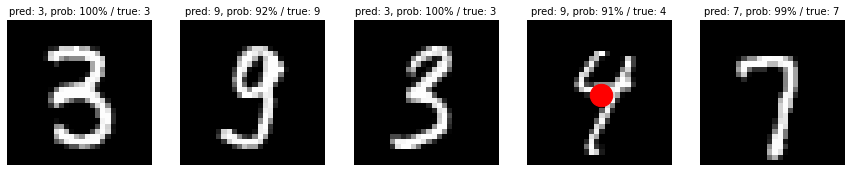

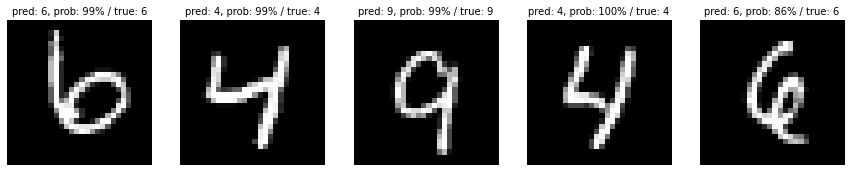

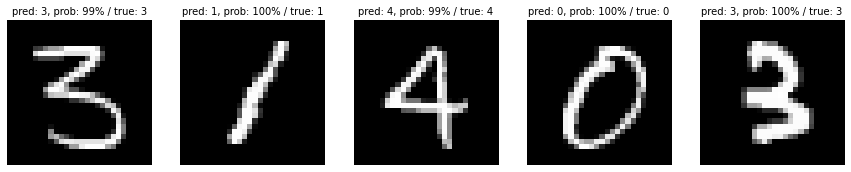

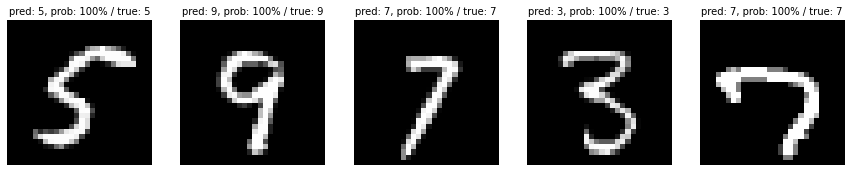

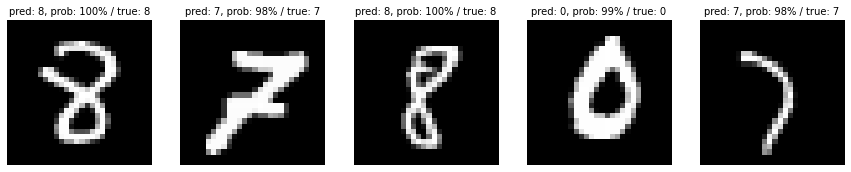

In [534]:
show_predictions(m=20)

### 3. Evaluation

* confusion matrix on the test set
* visualize mistakes (at least 16) in a grid, show the true and the predicted labels
* plot the ROC curve for each predicted class

In [535]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

Text(0.5, 103.73999999999997, 'Predicted')

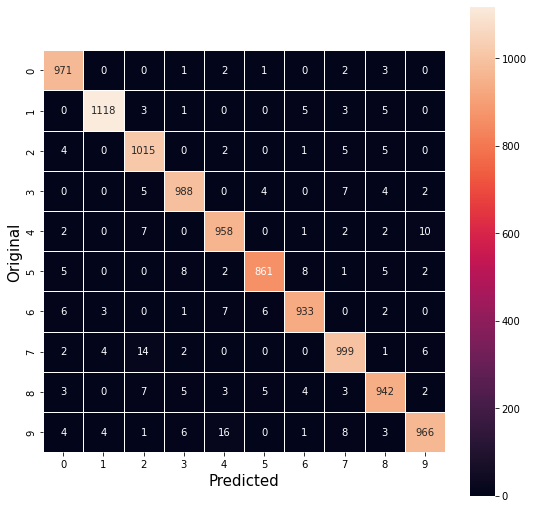

In [536]:
cm = metrics.confusion_matrix(y_test, class_labels)
plt.figure(figsize=(9,9))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True)
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)

#### Incorrect choices

In [537]:
preds = model.predict(x_test)
true_labels = y_test
incorrect = []
for i in range(len(preds)):
    if(preds[i].argmax() != true_labels[i]):
        incorrect.append(i)

In [538]:
def show_incorrects(n=10, m=10, fail = []):
    fig, ax = plt.subplots(nrows=m, ncols=n, figsize=(n+5,m+5))
    preds = model.predict(x_test)
    true_labels = y_test
    for j in range(m):
        for i in range(n):
            idx = fail[j*n+i]
            predstr = 'pred: ' + str(preds[idx].argmax()) + ', prob: ' + str(int(np.round(preds[idx].max()*100,0))) + '%'
            ax[j, i].imshow(x_test[idx].reshape(28, 28)*255, cmap='gray')
            ax[j, i].set_title(predstr + ' / true: ' + str(true_labels[idx]),fontsize=10)
    fig.tight_layout()
    plt.show()       

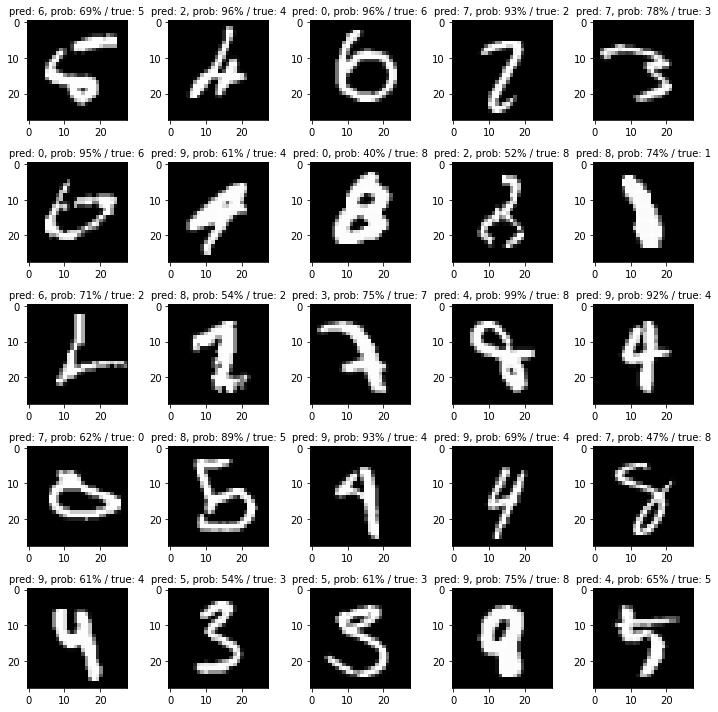

In [539]:
show_incorrects(n=5,m=5,fail=incorrect)

#### ROC curve with Log scale for easier determination

In [540]:
y_pred_prob = model.predict(x_test)
# Compute ROC curve and ROC area for each class
fpr_5 = dict()
tpr_5 = dict()
roc_auc = dict()
for i in range(np.shape(y_test_oh)[1]):
    fpr_5[i], tpr_5[i], _ = metrics.roc_curve(y_test_oh[:,i], y_pred_prob[:, i])
    roc_auc[i] = metrics.auc(fpr_5[i], tpr_5[i])

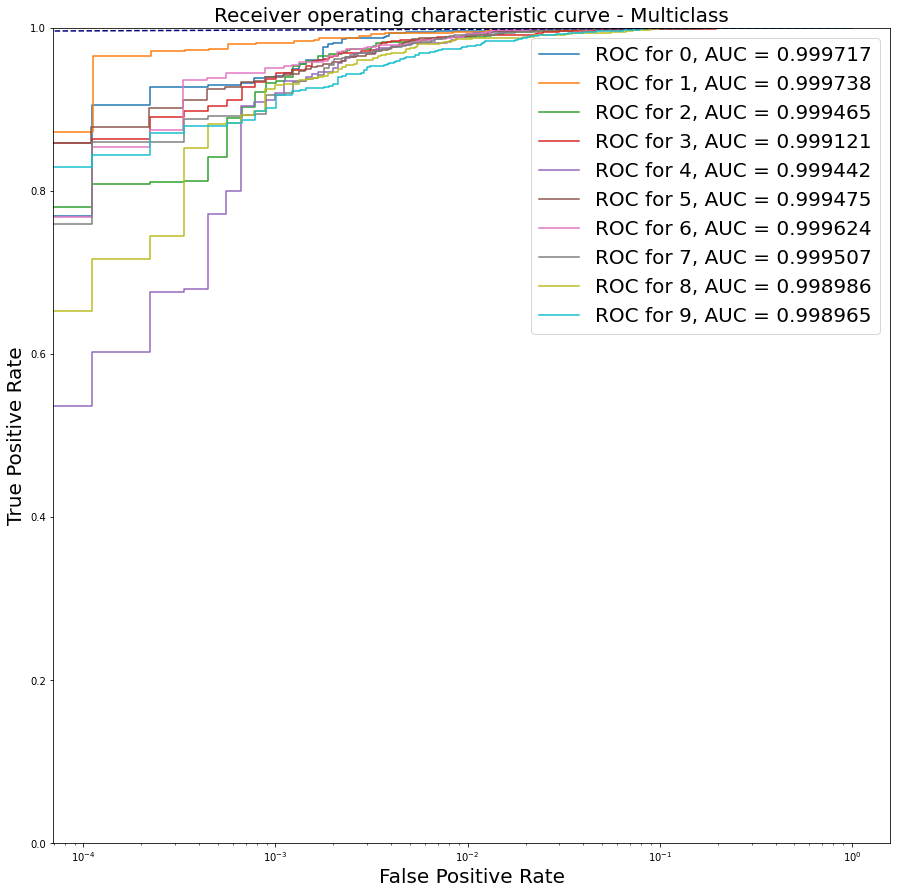

In [541]:
plt.figure(figsize=(15,15))
for i in range(np.shape(y_test_oh)[1]):
    plt.plot(fpr_5[i],tpr_5[i], label='ROC for %s, AUC = %f' %(i,roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver operating characteristic curve - Multiclass',fontsize=20)
plt.ylim(0.0,1.0)
plt.legend(fontsize=20)
plt.xscale('log')
plt.show()

### 4. Come up with your own model

* come up with your own small model (< 100'000 neurons)
* train it for 50 epochs
* visualize the loss for train/test on the same plot
  * what are your thoughs on the phenomenon?
* plot the ROC curves and the AUC scores

Found this really good guide, but ultimately didn't follow up as I was out of time.

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
    

In [542]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

### 5. Experiment with the CIFAR10 dataset

* preprocess the data, modify the models accordingly
  * train your small model as well as the model in the 3rd task on the CIFAR10 dataset
* compare the results
* are these models powerful enough to fit this data?


Hints:
On total you can get 10 points for fully completing all tasks.
Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
Comments you code when necessary
Write functions for repetitive tasks!
Use the pandas package for data loading and handling
Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
Use the scikit learn package for almost everything
Use for loops only if it is really necessary!
Code sharing is not allowed between student! Sharing code will result in zero points.
If you use code found on web, it is OK, but, make its source clear!